# Some Preprocessing

Import the different libraries and the data
Transforming categorical feeature into dummies...

In [1]:
#Packages needed
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Methods needed
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

plt.style.use('ggplot')
pd.set_option('display.float_format',lambda x : '%.2f' % x)
sns.set(style='darkgrid')

dataset = pd.read_csv("../data/cleanData.csv")


In [2]:
dataset['support_type']

0       Strainer Original
1       Strainer Original
2       Strainer Original
3       Strainer Original
4       Strainer Original
              ...        
203    Stretcher Original
204     Strainer Original
205    Stretcher Original
206         Stretcher New
207    Stretcher Original
Name: support_type, Length: 208, dtype: object

We want to capture the features that have the greatest Mutual Information with the columns we want to predict.
But first we try to get dummy variables for every categorical feature we think can have an impact on our predictions.

In [3]:
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
dataset['media_condition'] = dataset['media_condition'].fillna('Condition Unspecified')
dataset['auxiliary_support_condition'] = dataset['auxiliary_support_condition'].fillna('Condition Unspecified')

one_hot = pd.get_dummies(dataset['ground_layer_limit'])
MIData = dataset.drop('ground_layer_limit', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['ground_layer_application'])
MIData = MIData.drop('ground_layer_application', axis=1)
MIData = MIData.join(one_hot, lsuffix="limit", rsuffix="application")

one_hot = pd.get_dummies(dataset['ground_layer_thickness'])
MIData = MIData.drop('ground_layer_thickness', axis=1)
MIData = MIData.join(one_hot, rsuffix="thickness")

one_hot = pd.get_dummies(dataset['support_type'])
MIData = MIData.drop('support_type', axis=1)
MIData = MIData.join(one_hot, lsuffix="thickness", rsuffix="supptype")

one_hot = pd.get_dummies(dataset['media_type_1'])
MIData = MIData.drop('media_type_1', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['media_condition'])
MIData = MIData.drop('media_condition', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['auxiliary_support_condition'])
MIData = MIData.drop('auxiliary_support_condition', axis=1)
MIData = MIData.join(one_hot, lsuffix='media_cond', rsuffix="aux_cond")

one_hot = pd.get_dummies(dataset['frame_material'])
MIData = MIData.drop('frame_material', axis=1)
MIData = MIData.join(one_hot, lsuffix="mediaType", rsuffix="frameMat")

one_hot = pd.get_dummies(dataset['collection'])
MIData = MIData.drop('collection', axis=1)
MIData = MIData.join(one_hot)

one_hot = pd.get_dummies(dataset['ground_condition'])
MIData = MIData.drop('ground_condition', axis=1)
MIData = MIData.join(one_hot, lsuffix="other_cond", rsuffix="ground_cond")

one_hot = pd.get_dummies(dataset['canvas'])
MIData = MIData.drop('canvas', axis=1)
MIData = MIData.join(one_hot, rsuffix="canvas")

MIData.columns = MIData.columns.astype(str)

MIDataCateg = MIData.select_dtypes( exclude=["float64", "object"]) # Selecting only categorical data
#MIDataCateg = MIData.select_dtypes( include=["object"])
#print(MIDataCateg.columns)
MIDataCateg = MIDataCateg.dropna()

miApp=pd.Series()
miLim=pd.Series()
miThic=pd.Series()

for feature in MIDataCateg.columns:
    scoreApp = mutual_info_score(MIDataCateg["Artist Applied Ground"], MIDataCateg[feature])
    scoreLim = mutual_info_score(MIDataCateg["To Face Edge"], MIDataCateg[feature])
    scoreThic = mutual_info_score(MIDataCateg["Thinly Applied"], MIDataCateg[feature])

    miApp[feature]= scoreApp
    miLim[feature]= scoreLim
    miThic[feature]= scoreThic

#miApp = mutual_info_classif(MIDataCateg, MIDataCateg["Artist Applied Ground"])
#miLim = mutual_info_classif(MIDataCateg, MIDataCateg["To Face Edge"])
#miThic = mutual_info_classif(MIDataCateg, MIDataCateg["Thinly Applied"])

/Users/samy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


The thickness of the ground layer and the limit of its application seem to have a correlation with the fact that the layer was applied by the artist or not. We will use these features and the others shown in the 

# Predicting `ground_layer_application`

## First splitting of the data (deprecated)

In [4]:
"""
dataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')
colnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 'ground_condition',
            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']
"""

"\ndataset['ground_condition'] = dataset['ground_condition'].fillna('Condition Unspecified')\ncolnames = ['ground_layer_application', 'ground_layer_limit', 'ground_layer_thickness', 'size_layer_visible', 'ground_condition',\n            'coloured_ground', 'id_sulphate', 'id_carbonate', 'uniform_application', 'ground_proprietary_paint', 'collection']\n"

One hot encode categorical data with more than two values

In [5]:
"""
prediction_set = dataset[colnames]
one_hot = pd.get_dummies(prediction_set['ground_layer_limit'])
prediction_set = prediction_set.drop('ground_layer_limit', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_layer_thickness'])
prediction_set = prediction_set.drop('ground_layer_thickness', axis=1)
prediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")

one_hot = pd.get_dummies(prediction_set['collection'])
prediction_set = prediction_set.drop('collection', axis=1)
prediction_set = prediction_set.join(one_hot)

one_hot = pd.get_dummies(prediction_set['ground_condition'])
prediction_set = prediction_set.drop('ground_condition', axis=1)
prediction_set = prediction_set.join(one_hot)
prediction_set.columns = prediction_set.columns.astype(str)
"""

'\nprediction_set = dataset[colnames]\none_hot = pd.get_dummies(prediction_set[\'ground_layer_limit\'])\nprediction_set = prediction_set.drop(\'ground_layer_limit\', axis=1)\nprediction_set = prediction_set.join(one_hot)\n\none_hot = pd.get_dummies(prediction_set[\'ground_layer_thickness\'])\nprediction_set = prediction_set.drop(\'ground_layer_thickness\', axis=1)\nprediction_set = prediction_set.join(one_hot, lsuffix="limit", rsuffix="thickness")\n\none_hot = pd.get_dummies(prediction_set[\'collection\'])\nprediction_set = prediction_set.drop(\'collection\', axis=1)\nprediction_set = prediction_set.join(one_hot)\n\none_hot = pd.get_dummies(prediction_set[\'ground_condition\'])\nprediction_set = prediction_set.drop(\'ground_condition\', axis=1)\nprediction_set = prediction_set.join(one_hot)\nprediction_set.columns = prediction_set.columns.astype(str)\n'

Split data into training, validation and testing set

In [6]:
#prediction_set.ground_layer_application

In [7]:
#X = prediction_set[(prediction_set['ground_layer_application'] != 'Unspecified') & (prediction_set['ground_layer_application'] != 'Unsure')]
#test = prediction_set[(prediction_set['ground_layer_application'] == 'Unspecified') | (prediction_set['ground_layer_application'] == 'Unsure')]

In [8]:
#y = X.ground_layer_application
#X = X.drop('ground_layer_application', axis=1)
#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=25)

In [9]:
#y_train.name

In [10]:
#X_test = test.drop('ground_layer_application', axis=1)

In [11]:
#X_train.shape, X_valid.shape

In [12]:
#X_test.shape

## Second splitting of the data

In [13]:
#Excluding the possible values for Gorund_layer_application
miApp = miApp.drop(labels=['Artist Applied Ground', 'Commercial Ground', 'Unspecifiedapplication', 'Unsure'])


In [14]:
indexApp = miApp.sort_values(ascending=False)[0:20].index

datagApp = MIDataCateg[indexApp].join(dataset['ground_layer_application'])

Xbis = datagApp[(datagApp['ground_layer_application'] != 'Unspecified') & (datagApp['ground_layer_application'] != 'Unsure')]
testbis = datagApp[(datagApp['ground_layer_application'] == 'Unspecified') | (datagApp['ground_layer_application'] == 'Unsure')]

ybis = Xbis.ground_layer_application
Xbis = Xbis.drop('ground_layer_application', axis=1)
Xb_train, Xb_valid, yb_train, yb_valid = train_test_split(Xbis, ybis, test_size=0.3, random_state=25)

Xb_test = testbis.drop('ground_layer_application', axis=1)

[Text(0.5, 1.0, 'Distribution of ground_layer_application in the original set')]

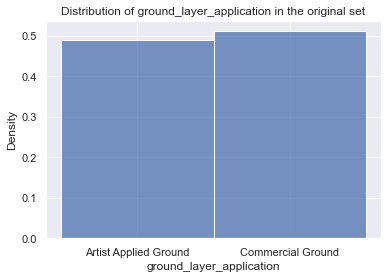

In [15]:
sns.histplot(ybis, stat="density").set(title='Distribution of ground_layer_application in the original set')

[Text(0.5, 1.0, 'Distribution of ground_layer_application in the training set')]

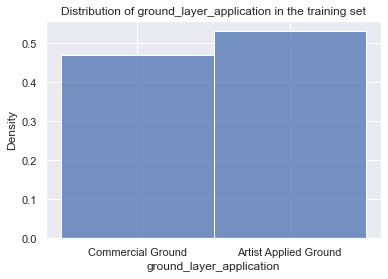

In [16]:
sns.histplot(yb_train, stat="density").set(title='Distribution of ground_layer_application in the training set')

[Text(0.5, 1.0, 'Distribution of ground_layer_application in the testing set')]

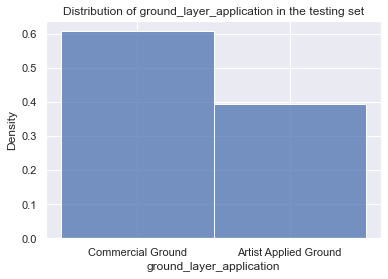

In [17]:
sns.histplot(yb_valid, stat="density").set(title='Distribution of ground_layer_application in the testing set')

In [18]:
#Looking at the splitting
print( "Length of the training set: "+ str(len(yb_train)))
print( "Length of the testing set: "+ str(len(yb_valid)))
print( "Length of the predicting set: "+ str(len(testbis)))

print("\nTotal : " + str(len(yb_train)+len(yb_valid)+len(testbis)))

Length of the training set: 128
Length of the testing set: 56
Length of the predicting set: 24

Total : 208


## Baseline model: Bernoulli Naive Bayes

In [19]:
switch={
      'ground_layer_application':['Artist Applied', 'Commercial'],
      'ground_layer_limit':['To Face Edge', 'To Side Edge'],
      'ground_layer_thickness':['Thinly Applied', 'Thickly Applied'],
}
def NB_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a Naive Bayes model, plot a confusion matrix and return the prediction for the unspecified data.
    """
    bnb = BernoulliNB()
    bnb.fit(Xtrain, ytrain)
    print("Training Accuracy:", bnb.score(Xtrain, ytrain))
    print("Holdout Accuracy:", bnb.score(Xvalid, yvalid))
     
    feature = ytrain.name

    valid_prediction = bnb.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
            yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Bernoulli Naive Bayes')
    plt.show() 

    test_prediction = bnb.predict(Xtest)
    return(test_prediction)

Training Accuracy: 0.8515625
Holdout Accuracy: 0.8214285714285714


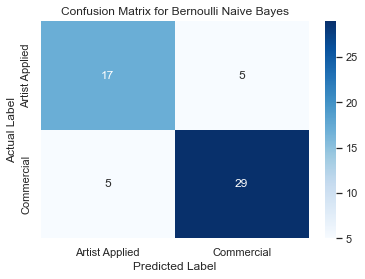

In [20]:
pred = NB_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

In [21]:
print("Training data class distribution: ", Counter(yb_train))
print("Validation data class distribution: ", Counter(yb_valid))
print("Validation prediction distribution: ", Counter(pred))

Training data class distribution:  Counter({'Artist Applied Ground': 68, 'Commercial Ground': 60})
Validation data class distribution:  Counter({'Commercial Ground': 34, 'Artist Applied Ground': 22})
Validation prediction distribution:  Counter({'Commercial Ground': 15, 'Artist Applied Ground': 9})


Print predictions

In [22]:
print(pred)

['Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Commercial Ground' 'Artist Applied Ground'
 'Artist Applied Ground' 'Commercial Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Commercial Ground'
 'Artist Applied Ground' 'Artist Applied Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Artist Applied Ground' 'Artist Applied Ground'
 'Commercial Ground' 'Commercial Ground' 'Commercial Ground']


## Random forest classifier

In [23]:
def RF_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a Random Forest classifier, plot a confusion matrix and return the prediction for the unspecified data.
    """
    param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
    }
    rfc=RandomForestClassifier(random_state=42)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
    CV_rfc.fit(Xtrain.append(Xvalid), ytrain.append(yvalid))   
    bestparam=CV_rfc.best_params_
    #Add also a n_estimator exploration step Gridsearch for both estimators and max_depth

    #mean_valid_score = np.mean(validation_scores, axis=1)
    #bestparam = param_range[mean_valid_score.argmax()]

    rfc = RandomForestClassifier(max_depth=bestparam['max_depth'], n_estimators=bestparam['n_estimators'],
     criterion =bestparam['criterion'], max_features=bestparam['max_features'] , random_state=10)
    rfc.fit(Xtrain, ytrain)
    print("Training Accuracy:", rfc.score(Xtrain, ytrain))
    print("Holdout Accuracy:", rfc.score(Xvalid, yvalid))

    valid_prediction = rfc.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)
    feature=ytrain.name

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
        xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
        yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Random Forest Classifier')
    plt.show() 

    test_prediction = rfc.predict(Xtest)
    return(test_prediction)

Training Accuracy: 1.0
Holdout Accuracy: 0.8392857142857143


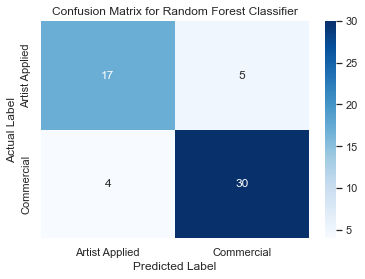

In [24]:
predbis = RF_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

### old Hyperparameter tuning for tree depth

In [25]:
"""param_range = np.arange(2, 20)
train_score, validation_scores = validation_curve(
    RandomForestClassifier(n_estimators=100, random_state=10), X, y, param_name='max_depth', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
)
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
mean_valid_score = np.mean(validation_scores, axis=1)
std_valid_score = np.std(validation_scores, axis=1)
plt.semilogx(param_range, mean_train_score, label='Training Score', color='b')
plt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')
plt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')
plt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')
plt.legend(loc='best')
plt.title('Validation Curve for Maximum Depth in RandomForestClassifier')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.show()"""

"param_range = np.arange(2, 20)\ntrain_score, validation_scores = validation_curve(\n    RandomForestClassifier(n_estimators=100, random_state=10), X, y, param_name='max_depth', cv=5,\n    param_range=param_range, n_jobs=-1, verbose=-1\n)\nmean_train_score = np.mean(train_score, axis=1)\nstd_train_score = np.std(train_score, axis=1)\nmean_valid_score = np.mean(validation_scores, axis=1)\nstd_valid_score = np.std(validation_scores, axis=1)\nplt.semilogx(param_range, mean_train_score, label='Training Score', color='b')\nplt.fill_between(param_range, mean_train_score - std_train_score, mean_train_score + std_train_score, alpha=0.2, color='y')\nplt.semilogx(param_range, mean_valid_score, label='Cross Validation Score', color='r')\nplt.fill_between(param_range, mean_valid_score - std_valid_score, mean_valid_score + std_valid_score, alpha=0.2, color='c')\nplt.legend(loc='best')\nplt.title('Validation Curve for Maximum Depth in RandomForestClassifier')\nplt.xlabel('Maximum Depth')\nplt.ylabel

## Logistic regression

In [26]:
def LR_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    """
    Fit a logistic regressor, plot a confusion matrix and return the prediction for the unspecified data.
    """
    param_range = np.logspace(-2, 2, 30)

    train_score, validation_scores = validation_curve(
    LogisticRegression(), Xtrain.append(Xvalid), ytrain.append(yvalid), param_name='C', cv=5,
    param_range=param_range, n_jobs=-1, verbose=-1
    )
    mean_valid_score = np.mean(validation_scores, axis=1)
    bestparam = param_range[mean_valid_score.argmax()]

    lr = LogisticRegression(C=bestparam)
    lr.fit(Xtrain, ytrain)
    print("Training Accuracy:", lr.score(Xtrain, ytrain))
    print("Holdout Accuracy:", lr.score(Xvalid, yvalid))

    valid_prediction = lr.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
        xticklabels = ['Artist Applied', 'Commercial'],
        yticklabels = ['Artist Applied', 'Commercial']) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Logistic regressor')
    plt.show() 

    test_prediction = lr.predict(Xtest)
    return((test_prediction, bestparam))
# Look at usual C values

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:   10.1s remaining: 12.5min
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Training Accuracy: 0.8515625
Holdout Accuracy: 0.8214285714285714


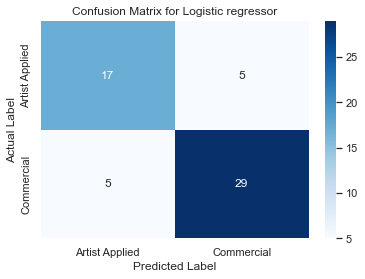

In [27]:
(predbLR, bestApp) = LR_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test)

## Stacking

In [28]:

def Stacking_analysis(Xtrain, ytrain, Xvalid, yvalid, Xtest, c):
    """
    Fit a stacking model, plot a confusion matrix and return the prediction for the unspecified data.
    """
    estimatorsb = [
    ('BNB', BernoulliNB()),
    ('Logistic', LogisticRegression(C=c, max_iter=1000)),
    ('RF', RandomForestClassifier(max_depth=12, n_estimators=100, random_state=10)), 
]
    clfb = StackingClassifier(
    estimators=estimatorsb, final_estimator=LogisticRegression(max_iter=1000)
)
    clfb.fit(Xb_train, yb_train)
    print("Training Accuracy:", clfb.score(Xtrain, ytrain))
    print("Holdout Accuracy:", clfb.score(Xvalid, yvalid))
     
    feature = ytrain.name

    valid_prediction = clfb.predict(Xvalid)
    cm = confusion_matrix(yvalid, valid_prediction)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues',
            xticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized']),
            yticklabels = switch.get(feature, ['feature non recognized', 'feature non recognized'])) 
    ax.set_xlabel('Predicted Label')    
    ax.set_ylabel('Actual Label')
    ax.set_title('Confusion Matrix for Stacking method')
    plt.show() 

    test_prediction = clfb.predict(Xtest)
    return(test_prediction)


Training Accuracy: 0.9140625
Holdout Accuracy: 0.8392857142857143


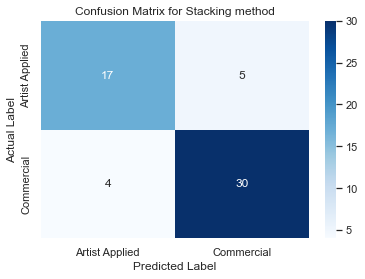

In [29]:
AppPred = Stacking_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test, c=bestApp)

# Predicting for `ground_layer_limit`

## Splitting the data

In [30]:
#Excluding the possible values for Gorund_layer_application
miLim = miLim.drop(labels=['To Face Edge', 'To Side Edge', 'Unspecifiedlimit'])

In [31]:
indexLim = miLim.sort_values(ascending=False)[0:20].index

datagLim = MIData[indexLim].join(dataset['ground_layer_limit'])

Xlim = datagLim[(datagLim['ground_layer_limit'] != 'Unspecified') & (datagLim['ground_layer_limit'] != 'Both') ]
#Got rid of 'Both' because only one data point presented it
testlim = datagLim[(datagLim['ground_layer_limit'] == 'Unspecified')]

ylim = Xlim.ground_layer_limit
Xlim = Xlim.drop('ground_layer_limit', axis=1)
Xlim_train, Xlim_valid, ylim_train, ylim_valid = train_test_split(Xlim, ylim, test_size=0.3, random_state=25, stratify=ylim)

Xlim_test = testlim.drop('ground_layer_limit', axis=1)

[Text(0.5, 1.0, 'Distribution of ground_layer_limit in the original set')]

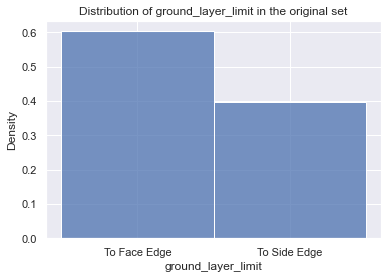

In [32]:
sns.histplot(ylim, stat="density").set(title='Distribution of ground_layer_limit in the original set')

[Text(0.5, 1.0, 'Distribution of ground_layer_limit in the training set')]

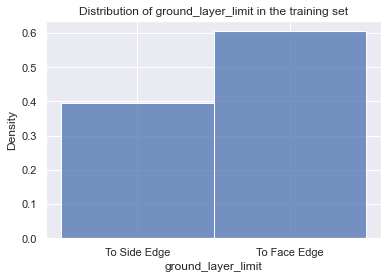

In [33]:
sns.histplot(ylim_train, stat="density").set(title='Distribution of ground_layer_limit in the training set')

[Text(0.5, 1.0, 'Distribution of ground_layer_limit in the testing set')]

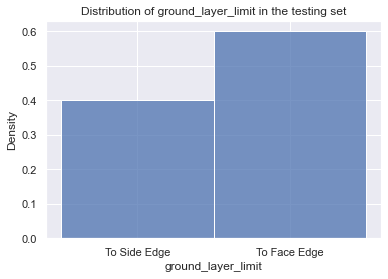

In [34]:
sns.histplot(ylim_valid, stat="density").set(title='Distribution of ground_layer_limit in the testing set')

In [35]:
#Looking at the splitting
print( "Length of the training set: "+ str(len(ylim_train)))
print( "Length of the testing set: "+ str(len(ylim_valid)))
print( "Length of the predicting set: "+ str(len(testlim)))

print("\nTotal : " + str(len(ylim_valid)+len(ylim_train)+len(testlim)))

Length of the training set: 81
Length of the testing set: 35
Length of the predicting set: 91

Total : 207


## Naive Bayes

Training Accuracy: 0.8148148148148148
Holdout Accuracy: 0.8285714285714286


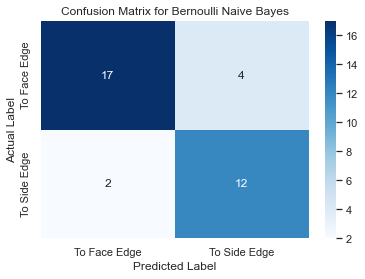

In [36]:
predlimNB = NB_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## RF

Training Accuracy: 0.9753086419753086
Holdout Accuracy: 0.8285714285714286


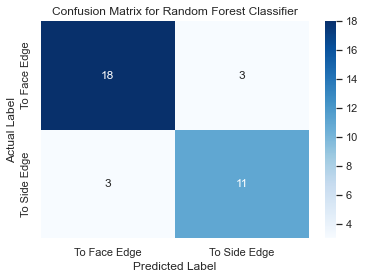

In [37]:
predlimRF = RF_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## Logistic Regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 101 | elapsed:    0.2s remaining:   12.3s
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Training Accuracy: 0.8518518518518519
Holdout Accuracy: 0.8857142857142857


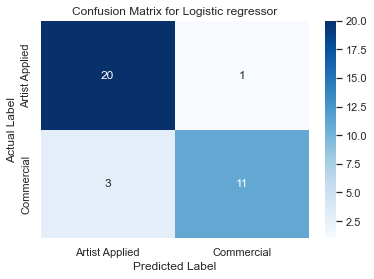

In [38]:
(predlimLR, bestLim) = LR_analysis(Xlim_train, ylim_train, Xlim_valid, ylim_valid, Xlim_test)

## Stacking

Training Accuracy: 0.921875
Holdout Accuracy: 0.8214285714285714


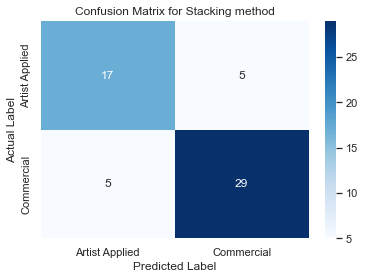

In [39]:
limPred = Stacking_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test, c=bestLim)

# Predicting for `ground_layer_thickness`

## Splitting the data

In [40]:
#Excluding the possible values for Gorund_layer_application
miThic = miThic.drop(labels=['Thinly Applied', 'Thickly Applied', 'Unspecifiedthickness'])

In [41]:
indexThic = miThic.sort_values(ascending=False)[0:20].index

datagThic = MIData[indexThic].join(dataset['ground_layer_thickness'])

Xthic = datagThic[(datagThic['ground_layer_thickness'] != 'Unspecified') & (datagThic['ground_layer_thickness'] != 'Both')]
#Got rid of 'Both' because only one data point presented it
testthic = datagThic[(datagThic['ground_layer_thickness'] == 'Unspecified')]

ythic = Xthic.ground_layer_thickness
Xthic = Xthic.drop('ground_layer_thickness', axis=1)
Xthic_train, Xthic_valid, ythic_train, ythic_valid = train_test_split(Xthic, ythic, test_size=0.3, random_state=25, stratify=ythic)

Xthic_test = testthic.drop('ground_layer_thickness', axis=1)

[Text(0.5, 1.0, 'Distribution of ground_layer_thickness in the original set')]

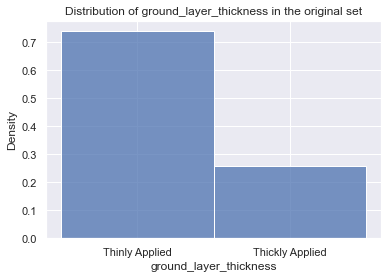

In [42]:
sns.histplot(ythic, stat="density").set(title='Distribution of ground_layer_thickness in the original set')

[Text(0.5, 1.0, 'Distribution of ground_layer_thickness in the training set')]

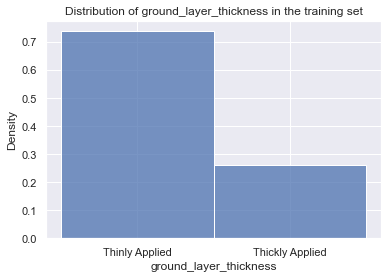

In [43]:
sns.histplot(ythic_train, stat="density").set(title='Distribution of ground_layer_thickness in the training set')

[Text(0.5, 1.0, 'Distribution of ground_layer_thickness in the testing set')]

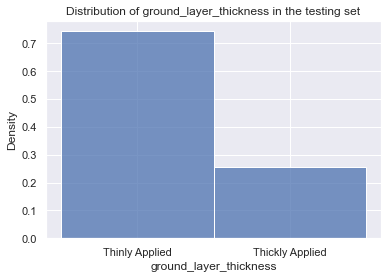

In [44]:
sns.histplot(ythic_valid, stat="density").set(title='Distribution of ground_layer_thickness in the testing set')

In [45]:
#Looking at the splitting
print( "Length of the training set: "+ str(len(ythic_train)))
print( "Length of the testing set: "+ str(len(ythic_valid)))
print( "Length of the predicting set: "+ str(len(testthic)))

print("\nTotal : " + str(len(ythic_train)+len(ythic_valid)+len(testthic)))

Length of the training set: 88
Length of the testing set: 39
Length of the predicting set: 80

Total : 207


## Naive Bayes

Training Accuracy: 0.8295454545454546
Holdout Accuracy: 0.7692307692307693


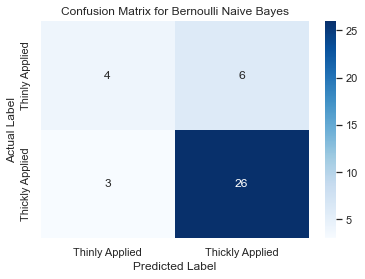

In [46]:
predthicNB = NB_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## RF

Training Accuracy: 0.9886363636363636
Holdout Accuracy: 0.8461538461538461


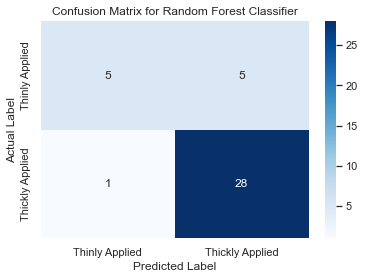

In [47]:
predthicSVM = RF_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## LR

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of 150 | elapsed:    9.6s remaining: 11.8min
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/Users/samy/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

Training Accuracy: 0.875
Holdout Accuracy: 0.7948717948717948


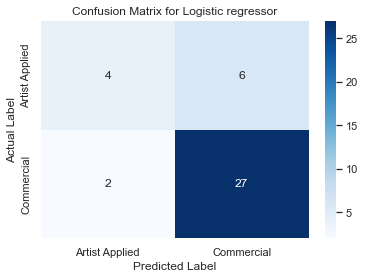

In [48]:
(predthicSVM, bestThic) = LR_analysis(Xthic_train, ythic_train, Xthic_valid, ythic_valid, Xthic_test)

## Stacking

Training Accuracy: 0.9140625
Holdout Accuracy: 0.8214285714285714


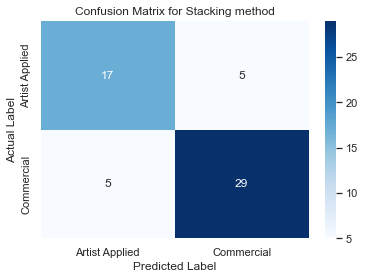

In [49]:
thicPred = Stacking_analysis(Xb_train, yb_train, Xb_valid, yb_valid, Xb_test, c=bestThic)